In [1]:
"""

Date: 3 Feb 2020

Python version:      3.7
Tensorboard version: 1.14.0
PyTorch version:     1.2.0

@author: Maksim Lavrov

CIFAR10

Only single convolutional layer, no flex
Max pooling following

"""

# imports
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# datasets
trainset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=transform)

#create a dataset subset to reduce training time

sampler_train = list(range(0, len(trainset), 5000))
sampler_test = list(range(0, len(testset), 5000))
#trainset_samp = torch.utils.data.Subset(trainset, sampler_train)
#testset_samp = torch.utils.data.Subset(testset, sampler_test)

#set size of batch and learning rate
batch_size=4
lr=0.001

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features= 3 * 56 * 56, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10) # number of classes

    def forward(self, t):
        
        # (1) hidden conv layer
        t = F.relu(self.conv2(t))
        #t = F.max_pool2d(t, kernel_size=2, stride=2)
        # (4) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 3 * 56 * 56))) #  3 * 12 * 12 * 12
        # (5) hidden linear layer
        t = F.relu(self.fc2(t))
        # (6) output layer
        t = self.out(t)
        
        return t

net = Net()

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [4]:
# helper functions

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

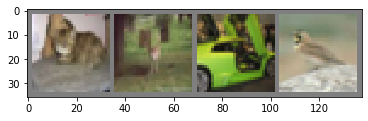

  cat  deer   car  bird


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
#from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter(comment=f'2_Bigdataset_test1-Optimisation-Xavier  batch_size={batch_size} lr={lr}')

<Figure size 432x288 with 0 Axes>

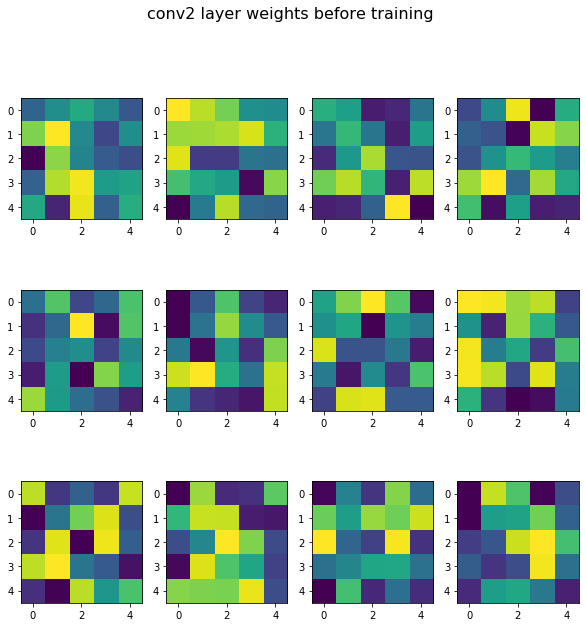

In [7]:
# plot the flex weights before training

fig = plt.figure()
plt.figure(figsize=(10,10))
plt.suptitle('conv2 layer weights before training', fontsize = 16)
for idx, filt  in enumerate(net.conv2.weight.detach().numpy()[:,0,:,:]):
    plt.subplot(3,4, idx + 1)
    plt.imshow(net.conv2.weight.detach().numpy()[idx,0,:,:]) # , cmap="gray"

    
fig.show()

In [8]:
running_loss = 0.0
total_loss_plt = []
for epoch in range(25):  # loop over the dataset multiple times
    
    total_loss = 0
    total_correct = 0
    
    nsamples = 1000

    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        preds = net(inputs) # Pass batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_correct += get_num_correct(preds, labels)
    
    # ...log the total epoch accuracy
    # writer.add_scalar('Accuracy', total_correct / len(trainset), epoch)
       
    total_loss_plt.append(total_loss)
        
    print("epoch:", epoch, "loss:", total_loss)
        
print('Finished Training')

epoch: 0 loss: 78515.08354574442
epoch: 1 loss: 64565.27312763035
epoch: 2 loss: 56887.5649260059
epoch: 3 loss: 50101.62056441791
epoch: 4 loss: 43732.39614350628
epoch: 5 loss: 38370.919384991284
epoch: 6 loss: 33090.26105797733
epoch: 7 loss: 28673.13912423505
epoch: 8 loss: 25699.854901695362
epoch: 9 loss: 22160.84249601954
epoch: 10 loss: 19618.336417587256
epoch: 11 loss: 17251.44289511824
epoch: 12 loss: 15624.13033760299
epoch: 13 loss: 14673.375615566778
epoch: 14 loss: 12572.020974340472
epoch: 15 loss: 12356.199426400211
epoch: 16 loss: 12076.639167249483
epoch: 17 loss: 10412.32654222516
epoch: 18 loss: 10843.799703558163
epoch: 19 loss: 10176.54493378608
epoch: 20 loss: 8731.848098144621
epoch: 21 loss: 8610.040857234271
epoch: 22 loss: 9361.681886702729
epoch: 23 loss: 8664.075381178829
epoch: 24 loss: 7636.373785754558
Finished Training


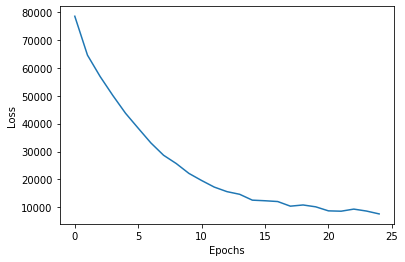

In [9]:
plt.plot(total_loss_plt)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [10]:
print('Accuracy is ', total_correct / len(trainset))

Accuracy is  0.95398


<Figure size 432x288 with 0 Axes>

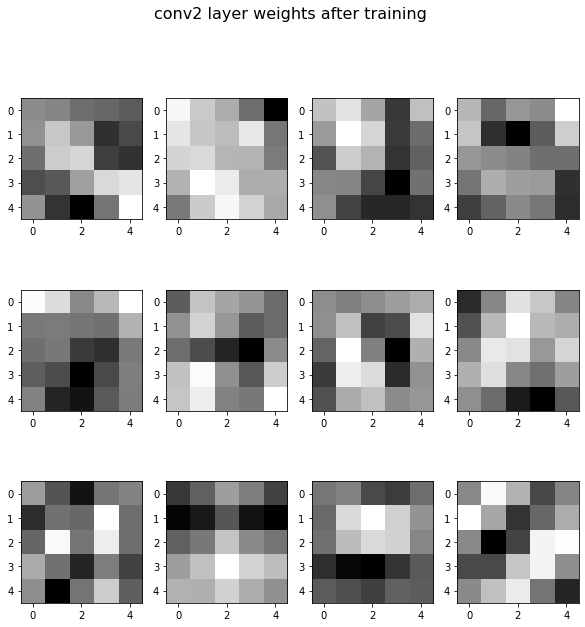

In [11]:
# plot the conv2 weights after training

fig = plt.figure()
fig = plt.figure(figsize=(10,10))
plt.suptitle('conv2 layer weights after training', fontsize = 16)
for idx, filt  in enumerate(net.conv2.weight.detach().numpy()[:,0,:,:]):
    im = plt.subplot(3,4, idx + 1)
    plt.imshow(net.conv2.weight.detach().numpy()[idx,0,:,:], cmap="gray")
#plt.colorbar()

    
fig.show()